# HSQL v2 calculation

This notebook calculates HQSL for Santiago's project using as base data document:
* __*'High Quality Societal Life Methodological guidelines'*__ from Chaire ETI (Entrepreneuriat Territoire Innovation) of IAE Parise Sorbonne Business School.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [2]:
import h3
def neighbour_mean(hex_id, hex_id_name, hex_bins, col_name):
    return hex_bins.loc[hex_bins[hex_id_name].isin(h3.k_ring(hex_id,1)),col_name].mean()

## Config notebook

In [3]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False
# How to save?
if_exists='append'

##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [4]:
# 'alex' or 'edgar'
all_local_dirs = 'alex'
# Output hexs resolution
res = 9

In [5]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/external/temporal_todocker/santiago/proximidad/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/santiago/"
else:
    print("WARNING: Fix all_local_dirs variable")

In [14]:
# --- REQUIRED DATA: parameters dictionary [AS OF 2024 06 28]
# Structure: {social_functions:{themes:[source_names]}}
parameters_dict = {'supplying':{'wellbeing':['carniceria', #Accessibility to Butcher/Fish Shops
                                             'hogar', #Accessibility to Hardware/Paint Shops
                                             #Not available: Accessibility to Greengrocers
                                             'bakeries', #Accessibility to Bakeries and delis
                                             'supermercado',#Accessibility to supermarkets
                                             'banco'#Accessibility to bank
                                            ],
                                'sociability':['ferias',#Accessibility to city fairs/markets
                                               'local_mini_market',#Accessibility to local and mini markets
                                               'correos'#ADDED: MAIL SERVICE
                                              ],
                                'environmental_impact':['centro_recyc'#Accessibility to recycling center
                                                        #Not available: Accessibility to compost
                                                       ]
                               },
                   'caring':{'wellbeing':['hospital_priv','hospital_pub',#Accessibility to hospital
                                          'clinica_priv','clinica_pub',#Accessibility to public clinics
                                          'farmacia',#Accessibility to pharmacies
                                          'vacunatorio_priv','vacunatorio_pub',#Accessibility to vaccination center
                                          'consult_ado_priv','consult_ado_pub',#Accessibility to optician/audiologist(###ADDED DENTIST)
                                          'salud_mental',###ADDED: MENTAL HEALTH
                                          'labs_priv',###ADDED: LABORATORIES
                                          'residencia_adumayor'###ADDED: ELDERLY PERMANENT RESIDENCIES
                                         ],
                             'sociability':['eq_deportivo_pub','eq_deportivo_priv',#Accessibility to sports equipments
                                            'club_deportivo'#Accessibility to sport clubs
                                           ],
                             'environmental_impact':[#Not available: Air polution
                                                     #Not available: Noise
                                                     #Not available: Heat islands
                                                    ]
                            },
                   'living':{'wellbeing':['civic_office',#Accessibility to civic offices
                                          #Not available: Number of street bentches
                                          'tax_collection',#ADDED: AFIP(TAX COLLECTOR)
                                          'social_security',#ADDED: SOCIAL SECURITY
                                          'police',#Accessibility to police(###MOVED FROM LIVING TO CARING)
                                          'bomberos'#Accessibility to fire stations
                                          #Not available: Accessibility to street lamp
                                         ],
                             'sociability':['viv_sum',#Accessibility to permanent residencies
                                            'pct_social_viv',#Accessibility to social housing
                                            #Not available: Accessibility to student housing
                                            'pct_hotel'#ADDED: HOTELS
                                           ],
                             'environmental_impact':[#Not available: Corrected compactness
                                                     #Not available: Width of sidewalks
                                                     #Not available: Street connectivity
                                                    ],
                            },
                   'enjoying':{'wellbeing':['museos_priv','museos_pub',#Accessibility to museums
                                            #Not available: Accessibility to theater,operas
                                            'cines',#Accessibility to cinemas
                                            'sitios_historicos',#Accessibility to historical places
                                            'ndvi_mean'#Number of trees
                                           ],
                               'sociability':['restaurantes_bar_cafe',#Accessibility to bars/cafes + Accessibility to restaurants
                                              'librerias',#Accessibility to record and book stores, galleries, fairs
                                              #Not available: Accessibility to cultural and/or formative spaces
                                              #Not available: Accessibility to places of workship
                                              'ep_plaza_small'#Accessibility to boulevards, linear parks, small squares + Accessibility to squares
                                             ],
                               'environmental_impact':['ep_plaza_big'#Accessibility to big parks
                                                       #Not available: Accessibility to shared gardens
                                                       #Not available: Accessibility to urban playgrounds
                                                      ]
                              },
                   'learning':{'wellbeing':['edu_basica_pub',#'edu_basica_priv',#Accessibility to public elementary school
                                            'edu_media_pub',#'edu_media_priv',#Accessibility to public high school
                                            'jardin_inf_pub',#'jardin_inf_priv',#Similar to Accessibility to childcare
                                            'universidad',#Accessibility to university
                                            'edu_tecnica',#ADDED: TECHNICAL EDUCATION
                                           ],
                               'sociability':['edu_adultos_pub',#'edu_adultos_priv',#Accessibility to adult formation centers
                                              'edu_especial_pub',#'edu_especial_priv',#Accessibility to specialized educational centers
                                              #Not available: Accesibility to establishments and services for disabled adults
                                              'bibliotecas'#Accessibility to libraries(###MOVED FROM ENJOYING TO LEARNING)
                                             ],
                               'environmental_impact':['centro_edu_amb'#Accessibility to centers for learning environmental activities
                                                       #Not available: Accessibility to gardening schools
                                                      ],
                              },
                   'working':{'wellbeing':['paradas_tp',#Accessibility to bus stop
                                           'paradas_tp_metro',#Accessibility to metro
                                           'paradas_tp_tren'#Accessibility to train stop
                                          ],
                              'sociability':['oficinas_sum'#Accessibility to office
                                             #Not available: Accessibility to incubators
                                             #Not available: Accessibility to coworking places
                                          ],
                              
                              'environmental_impact':['ciclovias'#Accessibility to bike lanes
                                                      #Not available: Accessibility to shared bike stations
                                                     ]
                             }
                  }

weight_dict = {'carniceria':'rare', #SUPPLYING
               'hogar':'rare',
               'bakeries':'rare',
               'supermercado':'rare',
               'banco':'rare',
               'ferias':'rare',
               'local_mini_market':'rare',
               'correos':'rare',
               'centro_recyc':'rare',
               #CARING
               'hospital_priv':'very_rare', 'hospital_pub':'very_rare',
               'clinica_priv':'rare','clinica_pub':'rare',
               'farmacia':'rare',
               'vacunatorio_priv':'rare','vacunatorio_pub':'rare',
               'consult_ado_priv':'rare','consult_ado_pub':'rare',
               'salud_mental':'very_rare',
               'labs_priv':'rare',
               'residencia_adumayor':'rare',
               'eq_deportivo_priv':'rare','eq_deportivo_pub':'rare',
               'club_deportivo':'rare',
               #LIVING
               'civic_office':'rare', 
               'tax_collection':'very_rare',
               'social_security':'rare',
               'police':'rare',
               'bomberos':'rare',
               'viv_sum':'specific',
               'pct_social_viv':'specific',
               'pct_hotel':'rare',
               #ENJOYING
               'museos_priv':'rare', 'museos_pub':'rare',
               'cines':'rare',
               'sitios_historicos':'rare',
               'ndvi_mean':'specific',
               'restaurantes_bar_cafe':'frequent',
               'librerias':'rare',
               'ep_plaza_small':'frequent',
               'ep_plaza_big':'rare',
               #LEARNING
               'edu_basica_pub':'rare', 
               'edu_media_pub':'rare',
               'jardin_inf_pub':'rare',
               'universidad':'rare',
               'edu_tecnica':'rare',
               'edu_adultos_pub':'rare',
               'edu_especial':'rare',
               'bibliotecas':'very_rare',
               'centro_edu_amb':'very_rare',
               'paradas_tp':'frequent',
               'paradas_tp_metro':'rare',
               'paradas_tp_tren':'very_rare',
               'oficinas_sum':'frequent',
               'ciclovias':'rare'
              }

## __Load data__

### __Load data__ - Pois proximity (regular and unique ID pois)

In [9]:
query = f'SELECT * FROM projects_research.santiago_hexproximity_4_5_kmh WHERE res = {res}'
prox_gdf = aup.gdf_from_query(query)

# Show
print(prox_gdf.shape)
prox_gdf.head(1)

(30073, 118)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ep_plaza_small_time,ep_plaza_small_count_15min,ep_plaza_big_time,ep_plaza_big_count_15min,ciclovias_time,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city
0,89b2c0b0003ffff,"POLYGON ((-71.00923 -33.71126, -71.01041 -33.7...",108.459469,0.0,133.270428,0.0,93.054863,0.0,573.650638,0.0,...,92.049397,0.0,98.741183,0.0,62.537983,0.0,89.498868,0.0,9,Santiago


### __Load data__ - Specific analysis (hex_areal)

In [13]:
# From notebook 12-Areal-data-to-hex.ipynb
if all_local_dirs == 'alex':
    hex_dir = f"../../../data/processed/santiago/areal_data/hex_areal_res{res}.gpkg"
elif all_local_dirs == 'edgar':
    hex_dir = f'../../../data/processed/00_pois_formated/areal_data/hex_areal_res{res}.gpkg'

hex_areal = gpd.read_file(hex_dir)

# Show
print(hex_areal.shape)
hex_areal.head(1)

(9170, 8)


,hex_id,oficinas_sum,pct_hotel,viv_sum,pct_social_viv,ndvi_mean,res,geometry
0,89b2c55085bffff,0.057351,11.472761,0.0,NaN,0.018576,9,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4..."


### __POSIBLES PASOS POSTERIORES:__

__A)__ Antes que nada, crear la función que dependiendo de 'frequent', 'rare' o 'very_rare', utiliza una rúbrica de evaluación para dar una calificación del 0 al 10 a partir del f'{source}_count_15min' por row.

Posiblemente necesario cargar un hexgrid base que contenga todos los hexs (Porque una fuente es hex_gdf y otra es hex_areal)

__B)__ Para cada sf de parameters dict > para cada indicator de cada sf > Para cada source:
__B.1 >__ Revisar el weight de la source.
   
__B.2 >__ Si la source es 'frequent', 'rare' o 'very_rare', se van a usar los datos de prox_gdf
__B.2.1 >__ Se crea la columna f'{source}_score', basada en lo que haya en el count. Considerar que para 'pct_hotel' y 'oficinas_sum' se usa 'rare' y 'very_rare', pero no hay columna '_count_15min', se usa ese nombre de columna.
   
__B.3__ > Si la source es 'specific' necesita su propia calificación. (Por ahora viviendas, viviendas sociales y NDVI)


__B.4__ Una vez teniendo la score para todos, se necesita una nueva tabla de PONDERACIÓN por variable para ajustar cada '{source}_score' a esa ponderación. Sumar todas las ponderaciones para obtener la calificación por social function. (Por social function, la ponderación debe sumar 100)

__B.5__ El HQSL es la suma de las 6 social functions, va del 0 al 600.

__B.6__ Aún no se como se sacaría la calificación para cada uno de los tres indicadores (WELLBEING, SOCIABILITY, ENVIRONMENTAL IMPACT). Quizas para eso sea más útil solo promediar las calificaciones de todos los '{source}_score' que pertenecen a cada indicador.

# __FROM HERE ON, OLD CODE BELONGING TO HQSL_v1__

## Load data

### Load data - Load hexagons with proximity data

__Low resolution data__ -- used to extract max proximity opportunities

In [7]:
query = 'SELECT * FROM projects_research.santiago_hexproximity_4_5_kmh WHERE res = 8'
hex_low_res = aup.gdf_from_query(query)

# Show
print(hex_low_res.shape)
hex_low_res.head(1)

(4291, 118)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ep_plaza_small_time,ep_plaza_small_count_15min,ep_plaza_big_time,ep_plaza_big_count_15min,ciclovias_time,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city
0,88b2c0b5d9fffff,"POLYGON ((-70.86282 -33.80799, -70.86725 -33.8...",190.999017,0.0,224.67341,0.0,4.5806,1.0,636.436136,0.0,...,4.592671,1.888889,182.048447,0.0,102.399114,0.0,185.239877,0.0,8,Santiago


In [8]:
# From notebook 12-Aereal-data-to-hex.ipynb

if all_local_dirs == 'alex':
    hex_dir = "../../../data/processed/santiago/aereal_data/hex_aereal_res8.gpkg"
elif all_local_dirs == 'edgar':
    hex_dir = '../../../data/processed/00_pois_formated/aereal_data/hex_aereal_res8.gpkg'

hex_aereal_res8 = gpd.read_file(hex_dir)

# Show
print(hex_aereal_res8.shape)
hex_aereal_res8.head(1)

(1310, 7)


,hex_id,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count,geometry
0,88b2c550cbfffff,0.201249,3.010988,0.0,0.0,0.130288,"POLYGON ((-70.77163 -33.37549, -70.77605 -33.3..."


In [9]:
hex_low_res = hex_low_res.merge(hex_aereal_res8.drop(columns='geometry'),
                       on='hex_id',
                       how='right')
# Show
print(hex_low_res.shape)
hex_low_res.head(2)

(1310, 123)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,88b2c550cbfffff,"POLYGON ((-70.77163 -33.37549, -70.77605 -33.3...",23.226005,0.0,30.952702,0.0,42.249569,0.0,161.848656,0.0,...,0.0,77.053437,0.0,8.0,Santiago,0.201249,3.010988,0.0,0.0,0.130288
1,88b2c51859fffff,"POLYGON ((-70.49165 -33.33520, -70.49606 -33.3...",41.387994,0.0,51.758445,0.0,39.769928,0.0,129.364726,0.0,...,0.0,53.782026,0.0,8.0,Santiago,1.144057,0.000119,0.0,0.0,0.312631


__High resolution data__ -- used for HQSL urban analysis

In [10]:
query = f'SELECT * FROM projects_research.santiago_hexproximity_4_5_kmh WHERE res = {res}'
hex_gdf = aup.gdf_from_query(query)

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(30073, 118)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ep_plaza_small_time,ep_plaza_small_count_15min,ep_plaza_big_time,ep_plaza_big_count_15min,ciclovias_time,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city
0,89b2c0b0003ffff,"POLYGON ((-71.00923 -33.71126, -71.01041 -33.7...",108.459469,0.0,133.270428,0.0,93.054863,0.0,573.650638,0.0,...,92.049397,0.0,98.741183,0.0,62.537983,0.0,89.498868,0.0,9,Santiago


In [11]:
# From notebook 12-Aereal-data-to-hex.ipynb

if all_local_dirs == 'alex':
    hex_dir = f"../../../data/processed/santiago/aereal_data/hex_aereal_res{res}.gpkg"
elif all_local_dirs == 'edgar':
    hex_dir = f'../../../data/processed/00_pois_formated/aereal_data/hex_aereal_res{res}.gpkg'
    
hex_aereal = gpd.read_file(hex_dir)

# Show
print(hex_aereal.shape)
hex_aereal.head(1)

(9170, 7)


,hex_id,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count,geometry
0,89b2c55085bffff,0.0,0.0,0.0,0.0,0.018576,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4..."


In [12]:
hex_gdf = hex_gdf.merge(hex_aereal.drop(columns='geometry'),
                       on='hex_id',
                       how='right')
print(hex_gdf.shape)
hex_gdf.head(2)

(9170, 123)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,89b2c55085bffff,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4...",69.564997,0.0,53.321742,0.0,63.057446,0.0,173.61823,0.0,...,0.0,126.27579,0.0,9.0,Santiago,0.0,0.0,0.0,0.0,0.018576
1,89b2c509dc7ffff,"POLYGON ((-70.53795 -33.53054, -70.53912 -33.5...",0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.0,...,0.0,0.00000,0.0,9.0,Santiago,0.0,0.0,0.0,0.0,0.302082


<AxesSubplot: >

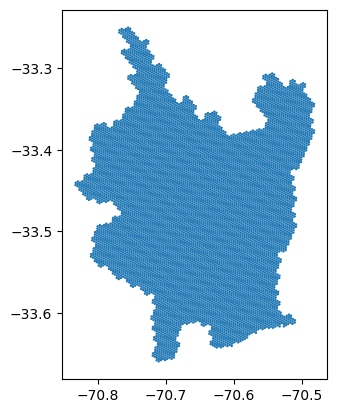

In [13]:
hex_gdf.plot()

## Process data - Create HQSL

HQSL definition

In [14]:
def calculate_hqsl(hex_gdf, hex_low_res, scale_max_value, parameters_dict):

    # ------------------------------------------------------------
    # --- NORMALIZE SOURCES (_scaledcount columns)
    for social_function in parameters_dict.keys():
        aup.log(f"--- {social_function}")
        for theme in parameters_dict[social_function]:
            aup.log(f"------ {theme}")
            for source in parameters_dict[social_function][theme]:

                # Set col name of interest and find min and max values
                if 'count' in source:
                    count_colname = source
                else:
                    count_colname = f"{source}_count_15min"

                # Prepare for MinMax Scalar
                hex_gdf[count_colname] = hex_gdf[count_colname] + 0.001
                min_val = np.log(0.001)
                max_val = np.log(hex_low_res[count_colname]).max()
                print(f"for col {count_colname} original max_val: {hex_gdf[count_colname].max()} and min_val: {hex_gdf[count_colname].min()}")
                print(f"for col {count_colname} log max_val: {max_val} and min_val: {min_val}")

                # Calculate MinMax Scalar
                # scale_max_value = 10
                hex_gdf[f"{source}_scaledcount"] = hex_gdf[count_colname].apply(lambda x: scale_max_value * ((np.log(x) - min_val) /(max_val - min_val)))
                hex_gdf.loc[hex_gdf[f"{source}_scaledcount"]>scale_max_value, f"{source}_scaledcount"] = scale_max_value
                aup.log(f"------ Scaled {source} count.")
                ''' # Drop original count col
                hex_gdf.drop(columns=[count_colname],inplace=True)
                # Add
                scalar_count_column_list.append(f"{source}_scaledcount")'''

    aup.log(f"--- Scaled count columns added to hex_gdf.")
    
    # Keep columns of interest only
    # proxhexs_countprocess = proxhexs_countprocess[['hex_id','geometry']+scalar_count_column_list+['res','city']]

    # ------------------------------------------------------------
    # --- SUM NORMALIZED SOURCES BY THEME AND BY SOCIAL FUNCTION
    aup.log(f"--- Starting social function analysis.")
    sum_count_column_list = []

    for social_function in parameters_dict.keys():
        # Set social function sources list
        sf_sources_list = []
        
        for theme in parameters_dict[social_function]:
            # Set theme_sources_list and feed sf_sources_list
            theme_sources_list = []
            for source in parameters_dict[social_function][theme]:
                theme_sources_list.append(f"{source}_scaledcount")
                sf_sources_list.append(f"{source}_scaledcount")
                
            # Find sum of count anlysis for theme
            hex_gdf[f"{theme}_count"] = hex_gdf[theme_sources_list].sum(axis=1)
            aup.log(f"------ Summed {theme} count with a mean value of " + str(round(hex_gdf[f"{theme}_count"].mean(),4)))
            sum_count_column_list.append(f"{theme}_count")
            
        # Find sum of count anlysis for social function
        hex_gdf[f"{social_function}_count"] = hex_gdf[sf_sources_list].mean(axis=1)
        aup.log(f"--- Summed {social_function} count with a mean value of {round(hex_gdf[f'{social_function}_count'].mean(),4)}.")
        sum_count_column_list.append(f"{social_function}_count")

    # ------------------------------------------------------------
    # --- NORMALIZE SOCIAL FUNCTION COLUMNS AND CREATE HQLS
    # Get social function count columns
    social_fn_cols = []
    for k in parameters_dict.keys():
        social_fn_cols.append(k+'_count')

    # Normalize social function columns before creating HQSL
    for sc in social_fn_cols:
        # aup.log(f"--- Normalized social function {sc} from 0 to 30.")
        # hex_gdf[sc] = 30 * (hex_gdf[sc] - hex_gdf[sc].min()) / (hex_gdf[sc].max() - hex_gdf[sc].min())
        aup.log(f"--- Filling missing hexagons")
        hex_gdf.loc[hex_gdf.supermercado_time==0, sc] = hex_gdf.loc[hex_gdf.supermercado_time==0].apply(lambda x: neighbour_mean(x['hex_id'],
                                                                            'hex_id',
                                                                            hex_gdf,
                                                                            sc), axis=1)

    # Create HQSL
    hex_gdf['hqsl'] = hex_gdf[social_fn_cols[0]] + hex_gdf[social_fn_cols[1]] + hex_gdf[social_fn_cols[2]] + hex_gdf[social_fn_cols[3]] + hex_gdf[social_fn_cols[4]] + hex_gdf[social_fn_cols[5]]
    aup.log(f"--- Calculated HQSL with a mean value of {round(hex_gdf['hqsl'].mean(),4)}.")
    
    return hex_gdf

Filter hexs with no nodes before running HQSL

In [15]:
hex_diss = hex_low_res.loc[hex_low_res.supermercado_time>0].dissolve()
hex_clip = gpd.clip(hex_gdf, hex_diss)
hex_id_list = list(hex_clip.hex_id.unique())
hex_gdf = hex_gdf.loc[hex_gdf.hex_id.isin(hex_id_list)].copy()

# Show
print(hex_gdf.shape)
hex_gdf.head(1)

(9121, 123)


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,ciclovias_count_15min,eleam_time,eleam_count_15min,res,city,viv_count,oficinas_count,hotel_count,viv_social_count,ndvi_count
0,89b2c55085bffff,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4...",69.564997,0.0,53.321742,0.0,63.057446,0.0,173.61823,0.0,...,0.0,126.27579,0.0,9.0,Santiago,0.0,0.0,0.0,0.0,0.018576


<AxesSubplot: >

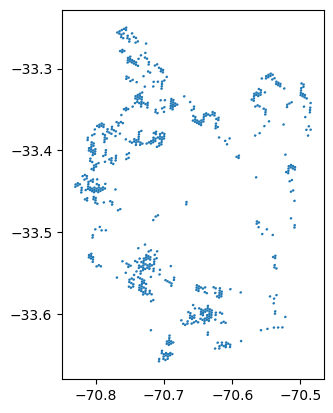

In [16]:
hex_gdf.loc[hex_gdf.supermercado_time==0].plot()

Calculate HQSL

In [17]:
hex_gdf = calculate_hqsl(hex_gdf, hex_low_res, 10, parameters_dict)

for col carniceria_count_15min original max_val: 10.001 and min_val: 0.001
for col carniceria_count_15min log max_val: 2.2079198664529676 and min_val: -6.907755278982137
for col hogar_count_15min original max_val: 27.001 and min_val: 0.001
for col hogar_count_15min log max_val: 3.0666840095262753 and min_val: -6.907755278982137
for col local_mini_market_count_15min original max_val: 94.21152631578948 and min_val: 0.001
for col local_mini_market_count_15min log max_val: 4.460121566456197 and min_val: -6.907755278982137
for col bakeries_count_15min original max_val: 50.353941176470585 and min_val: 0.001
for col bakeries_count_15min log max_val: 3.780748201004849 and min_val: -6.907755278982137
for col ferias_count_15min original max_val: 8.367666666666667 and min_val: 0.001
for col ferias_count_15min log max_val: 1.997425372002954 and min_val: -6.907755278982137
for col supermercado_count_15min original max_val: 14.629205128205127 and min_val: 0.001
for col supermercado_count_15min log m

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

for col sitios_historicos_count_15min original max_val: 64.79345283018868 and min_val: 0.001
for col sitios_historicos_count_15min log max_val: 3.983847174624248 and min_val: -6.907755278982137
for col ndvi_count original max_val: 0.6434853804137999 and min_val: -0.023265052740557044
for col ndvi_count log max_val: -0.7539983600866187 and min_val: -6.907755278982137
for col cines_count_15min original max_val: 9.717216216216215 and min_val: 0.001
for col cines_count_15min log max_val: 2.193341077309822 and min_val: -6.907755278982137
for col librerias_count_15min original max_val: 23.60477358490566 and min_val: 0.001
for col librerias_count_15min log max_val: 3.0029734348105506 and min_val: -6.907755278982137
for col restaurantes_bar_cafe_count_15min original max_val: 184.001 and min_val: 0.001
for col restaurantes_bar_cafe_count_15min log max_val: 5.057956282434942 and min_val: -6.907755278982137
for col jardin_inf_pub_count_15min original max_val: 13.501 and min_val: 0.001
for col jar

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

for col centro_edu_amb_count_15min original max_val: 1.001 and min_val: 0.001
for col centro_edu_amb_count_15min log max_val: 0.0 and min_val: -6.907755278982137
for col oficinas_count original max_val: 53.16564080937166 and min_val: 0.001
for col oficinas_count log max_val: 3.247319182424446 and min_val: -6.907755278982137
for col ciclovias_count_15min original max_val: 23.77877777777778 and min_val: 0.001
for col ciclovias_count_15min log max_val: 3.0842904052843805 and min_val: -6.907755278982137
for col paradas_tp_count_15min original max_val: 115.01236363636365 and min_val: 0.001
for col paradas_tp_count_15min log max_val: 4.665041210738592 and min_val: -6.907755278982137
for col paradas_tp_tren_count_15min original max_val: 2.001 and min_val: 0.001
for col paradas_tp_tren_count_15min log max_val: 0.5996211225491218 and min_val: -6.907755278982137
for col paradas_tp_metro_count_15min original max_val: 6.1642653061224495 and min_val: 0.001
for col paradas_tp_metro_count_15min log m

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

### Results review

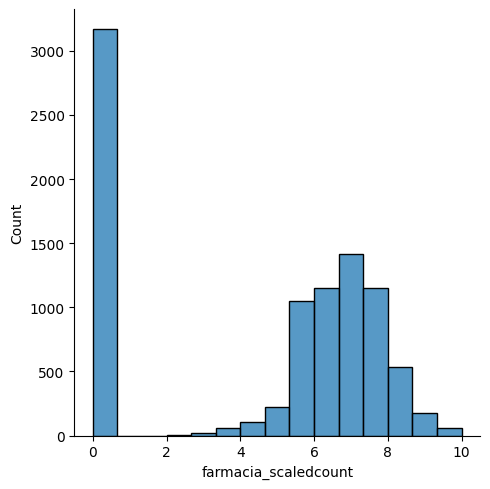

In [18]:
sns.displot(hex_gdf, x="farmacia_scaledcount")

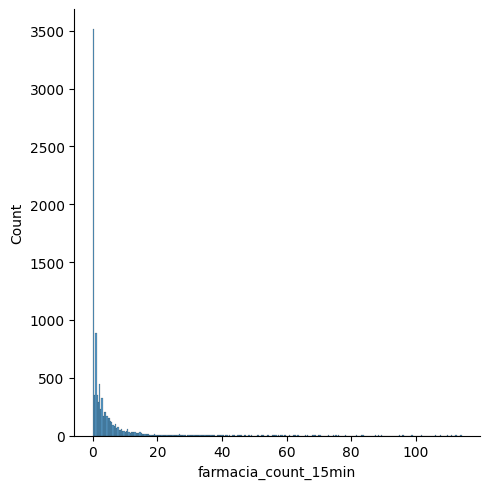

In [19]:
sns.displot(hex_gdf, x="farmacia_count_15min")

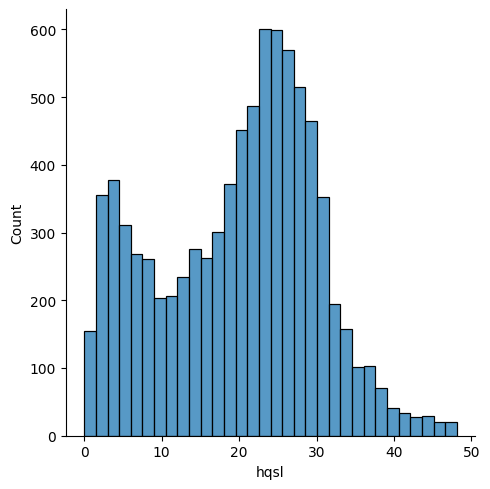

In [20]:
sns.displot(hex_gdf.loc[hex_gdf.supermercado_time>0],
            x=hex_gdf.loc[hex_gdf.supermercado_time>0,"hqsl"])

<AxesSubplot: >

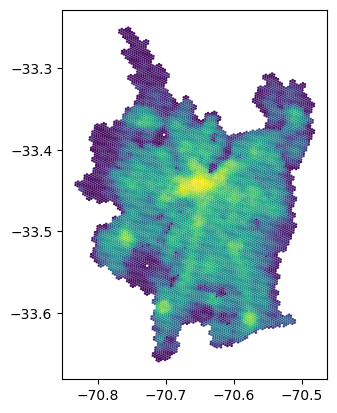

In [21]:
hex_gdf.plot('hqsl')

### Upload data

In [22]:
# Show
print(hex_gdf.shape)
print(hex_gdf.res.unique())
hex_gdf.head(1)

(9121, 201)
[9.]


,hex_id,geometry,supermercado_time,supermercado_count_15min,clinica_priv_time,clinica_priv_count_15min,clinica_pub_time,clinica_pub_count_15min,hospital_priv_time,hospital_priv_count_15min,...,culture_count,greenspace_count,entertainment_count,enjoying_count,education_count,learning_count,workplaces_count,sustainable_mobility_count,working_count,hqsl
0,89b2c55085bffff,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4...",69.564997,0.001,53.321742,0.001,63.057446,0.001,173.61823,0.001,...,0.0,4.8333,7.238974,1.509034,0.0,0.0,0.0,0.0,0.0,3.155563


In [23]:
if save:
    processed_table_name = 'santiago_hexproximity_hqsl_4_5_kmh_pub'
    aup.gdf_to_db_slow(hex_gdf, processed_table_name, 'projects_research', if_exists=if_exists)